In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam


In [2]:
train = pd.read_csv('data_mean_per_day/50841260_median_per_day_preprocessed.csv')

#get rid of column "id_jalan"
train = train.drop(['id_jalan'], axis=1)

train

,tanggal_hari,rerata_kecepatan,date
0,1,40.4365,2020-02-01
1,2,40.8650,2020-02-02
2,3,36.5405,2020-02-03
3,4,36.2140,2020-02-04
4,5,35.8350,2020-02-05
5,6,36.1060,2020-02-06
6,7,37.0810,2020-02-07
7,8,40.5870,2020-02-08
8,9,40.8310,2020-02-09
9,10,38.4640,2020-02-10


In [3]:
#doubling train row with itself
train = pd.concat([train, train, train, train, train, train, train, train], axis=0)

#restore index
train = train.reset_index(drop=True)

In [4]:
train

,tanggal_hari,rerata_kecepatan,date
0,1,40.4365,2020-02-01
1,2,40.8650,2020-02-02
2,3,36.5405,2020-02-03
3,4,36.2140,2020-02-04
4,5,35.8350,2020-02-05
...,...,...,...
171,18,39.1685,2020-02-18
172,19,37.9550,2020-02-19
173,20,36.4760,2020-02-20
174,21,39.6970,2020-02-21


In [5]:
train_data = train.iloc[:22*7] #sisa 22 data
test_data = train.iloc[22*7:]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data['rerata_kecepatan'].values.reshape(-1,1))

scaled_train_data = scaler.transform(train_data['rerata_kecepatan'].values.reshape(-1,1))
scaled_test_data = scaler.transform(test_data['rerata_kecepatan'].values.reshape(-1,1))


In [7]:
X_train, y_train = [], []
X_train.append(scaled_train_data[0:1,0])  # Duplicate the first entry
y_train.append(scaled_train_data[0,0])     # The target is the same as the first entry

for i in range(1, len(train_data)):
    X_train.append(scaled_train_data[i-1:i,0])
    y_train.append(scaled_train_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)


In [8]:
X_test, y_test = [], []
X_test.append(scaled_test_data[0:1,0])  # Duplicate the first entry
y_test.append(scaled_test_data[0,0])     # The target is the same as the first entry

for i in range(1, len(test_data)):
    X_test.append(scaled_test_data[i-1:i,0])
    y_test.append(scaled_test_data[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [9]:
model = Sequential()

# Increase units in the LSTM layers
model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False)) # Increase units in the LSTM layers

model.add(Dense(units=1))

# Use Adam optimizer with a learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error') # if your problem is a regression problem


In [10]:
history = model.fit(X_train, y_train, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
154/154 - 5s - loss: 0.1707 - 5s/epoch - 32ms/step
Epoch 2/30
154/154 - 0s - loss: 0.0909 - 457ms/epoch - 3ms/step
Epoch 3/30
154/154 - 0s - loss: 0.0937 - 468ms/epoch - 3ms/step
Epoch 4/30
154/154 - 0s - loss: 0.0855 - 449ms/epoch - 3ms/step
Epoch 5/30
154/154 - 0s - loss: 0.0860 - 500ms/epoch - 3ms/step
Epoch 6/30
154/154 - 0s - loss: 0.0866 - 463ms/epoch - 3ms/step
Epoch 7/30
154/154 - 0s - loss: 0.0883 - 462ms/epoch - 3ms/step
Epoch 8/30
154/154 - 0s - loss: 0.0879 - 455ms/epoch - 3ms/step
Epoch 9/30
154/154 - 1s - loss: 0.0904 - 561ms/epoch - 4ms/step
Epoch 10/30
154/154 - 0s - loss: 0.0873 - 451ms/epoch - 3ms/step
Epoch 11/30
154/154 - 1s - loss: 0.0903 - 562ms/epoch - 4ms/step
Epoch 12/30
154/154 - 1s - loss: 0.0881 - 621ms/epoch - 4ms/step
Epoch 13/30
154/154 - 1s - loss: 0.0874 - 526ms/epoch - 3ms/step
Epoch 14/30
154/154 - 1s - loss: 0.0874 - 509ms/epoch - 3ms/step
Epoch 15/30
154/154 - 1s - loss: 0.0853 - 547ms/epoch - 4ms/step
Epoch 16/30
154/154 - 0s - loss: 0.0

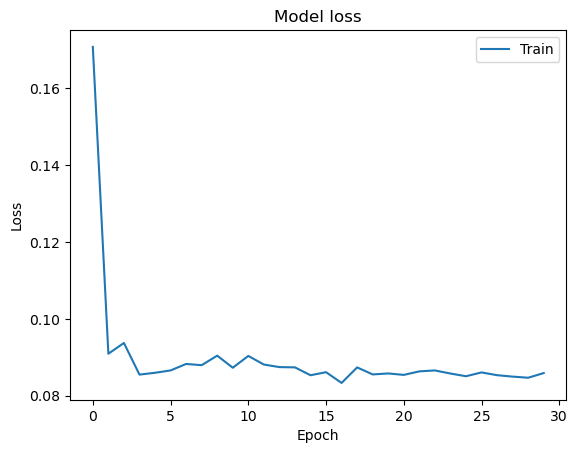

In [11]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()


In [12]:
def sMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Use the model to make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)

#reshape y_test back to original shape, before scaling
y_test = y_test.reshape(y_test.shape[0], 1)
y_test = scaler.inverse_transform(y_test)

# Calculate sMAPE
smape = sMAPE(y_test, y_pred_rescaled)

print(f'sMAPE: {smape}')

1/1 [==============================] - 2s 2s/step
sMAPE: 3.1728603287310637


In [13]:
#delete first data in y_pred_rescaled
y_pred_rescaled = y_pred_rescaled[1:]

#delete last data in y_test
y_test = y_test[:-1]

smape_changed = sMAPE(y_test, y_pred_rescaled)

print(f'sMAPE: {smape_changed}')

sMAPE: 1.969066550092555


In [14]:
predictions = model.predict(X_test)

1/1 [==============================] - 0s 34ms/step


In [15]:
predictions = scaler.inverse_transform(predictions)

In [16]:
predictions

array([[39.486084],
       [39.486084],
       [39.687347],
       [37.443096],
       [37.257015],
       [37.038784],
       [37.195065],
       [37.746876],
       [39.55735 ],
       [39.671562],
       [38.49664 ],
       [38.013996],
       [37.984985],
       [37.80634 ],
       [38.067215],
       [39.196102],
       [39.559708],
       [39.479187],
       [38.861507],
       [38.225616],
       [37.406487],
       [39.126995]], dtype=float32)

In [17]:
# mak "predictions" as dataframe``
predictions = pd.DataFrame(predictions)

#rename column 
predictions = predictions.rename(columns={0:'rerata_kecepatan'})

#change first row to last row
predictions.iloc[-1] = predictions.iloc[0]

#reset index
predictions = predictions.reset_index(drop=True)

predictions


,rerata_kecepatan
0,39.486084
1,39.486084
2,39.687347
3,37.443096
4,37.257015
5,37.038784
6,37.195065
7,37.746876
8,39.557350
9,39.671562


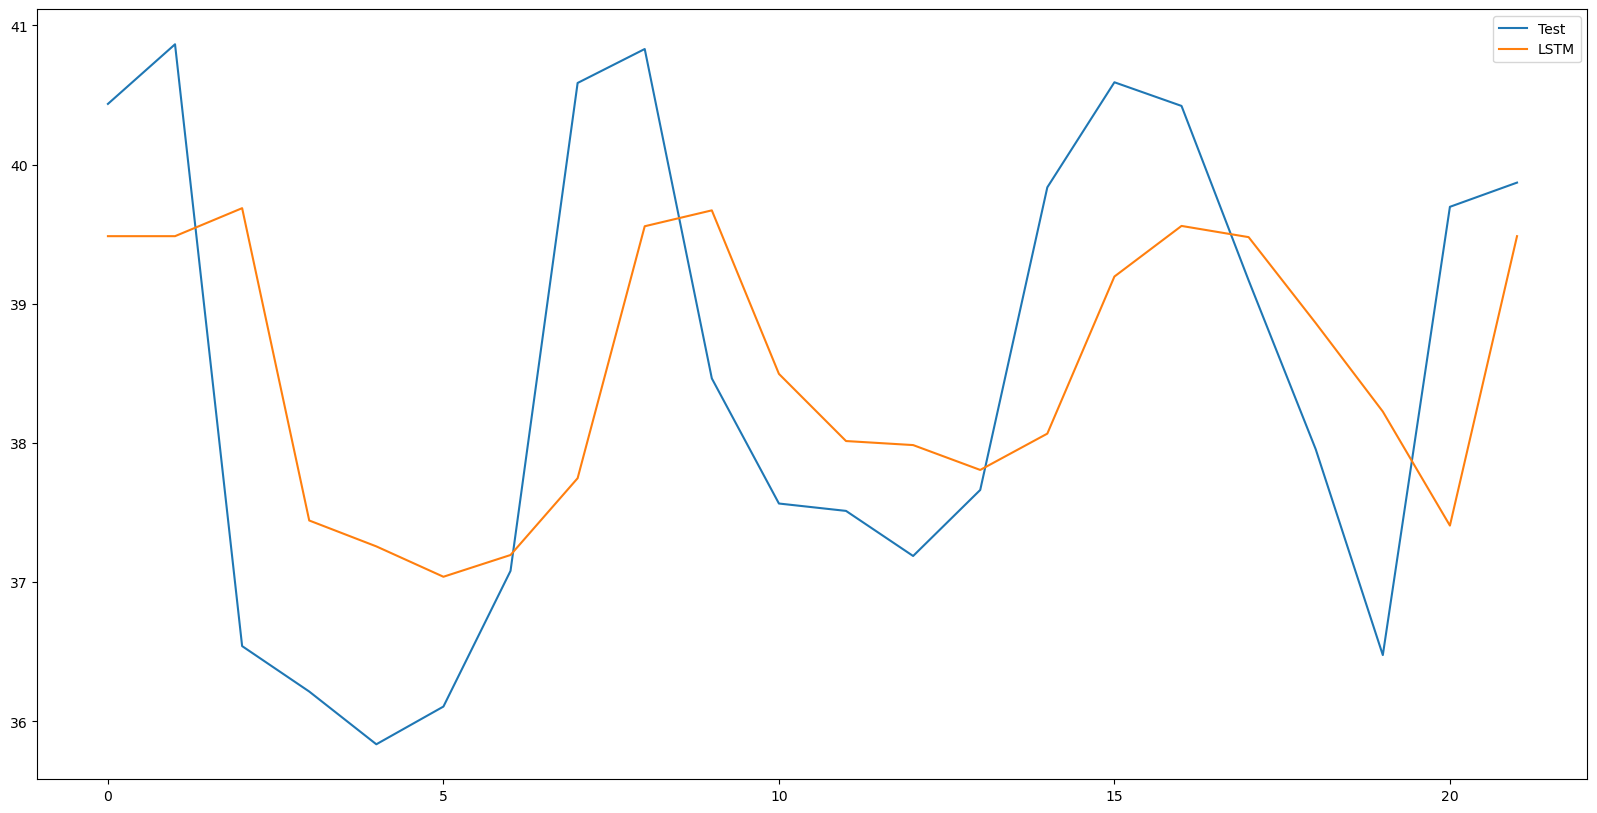

In [18]:
#plot train and predictions for column rerata_kecepatan, 
test_data.index = range(len(test_data))
plt.figure(figsize=(20,10))

plt.plot(test_data['rerata_kecepatan'], label='Test')
plt.plot(predictions['rerata_kecepatan'], label='LSTM')
plt.legend(loc='best')
plt.show()

# =====

In [19]:
# Last data point in test data
last_test_data = X_test[-1]

# Expand dimensions to match the input shape for the model
last_test_data = np.expand_dims(last_test_data, axis=0)

forecast = []

# Iterate over the next 7 days
for _ in range(7):
    # Make a prediction
    prediction = model.predict(last_test_data)

    # Append the prediction to the forecast
    forecast.append(prediction[0, 0])

    # Update the last data point to include the prediction
    last_test_data = np.roll(last_test_data, -1)
    last_test_data[0, -1] = prediction

# Convert the forecast to a numpy array
forecast = np.array(forecast)

print(forecast)


1/1 [==============================] - 0s 36ms/step
[0.65447223 0.5974857  0.56820637 0.55300534 0.5450717  0.54091996
 0.5387443 ]


In [20]:
# Convert forecast list to numpy array
forecast_np = np.array(forecast)

# Reshape it to 2D because scaler requires 2D array as input
forecast_np = forecast_np.reshape(-1, 1)

# Inverse transform the predictions
forecast_rescaled = scaler.inverse_transform(forecast_np)

# Convert the rescaled forecast back to a DataFrame
forecast_df = pd.DataFrame(forecast_rescaled, columns=['Prediction'])

forecast_df


,Prediction
0,39.126995
1,38.840355
2,38.693077
3,38.616619
4,38.576710
5,38.555828
6,38.544884


# ==

In [21]:
df = pd.read_csv('train.csv')

In [22]:
#get dataframe for only "4061596" in column id_jalan

df_4061596 = df[df['id_jalan'] == 4061596]

#drop column id_jalan and id_sensor
df_4061596 = df_4061596.drop(['id_jalan', 'id_titik_mulai', 'id_titik_akhir'], axis=1)

#get median of data that has same value in column 'x'
df_4061596 = df_4061596.groupby(['waktu_setempat']).median()

#ungrouping dataframe
df_4061596 = df_4061596.reset_index()

#separate first 10 word in column 'waktu_setempat' to column 'date
df_4061596['tanggal'] = df_4061596['waktu_setempat'].str[8:10]

#separate word 12-13 in column 'waktu_setempat' to column 'hour'
df_4061596['hour'] = df_4061596['waktu_setempat'].str[11:13]

#drop column 'waktu_setempat'
df_4061596 = df_4061596.drop(['waktu_setempat'], axis=1)

#change column 'tanggal' and 'hour' to int
df_4061596['tanggal'] = df_4061596['tanggal'].astype(int)

df_4061596

,rerata_kecepatan,tanggal,hour
0,37.8265,1,01
1,37.1880,1,02
2,38.6540,1,03
3,38.6650,1,04
4,39.9500,1,05
...,...,...,...
509,34.7910,22,19
510,34.6185,22,20
511,35.7375,22,21
512,36.3205,22,22


In [23]:
#add column "tanggal" from 1
predictions['tanggal'] = predictions.index + 1

predictions

,rerata_kecepatan,tanggal
0,39.486084,1
1,39.486084,2
2,39.687347,3
3,37.443096,4
4,37.257015,5
5,37.038784,6
6,37.195065,7
7,37.746876,8
8,39.557350,9
9,39.671562,10


In [24]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))

# Assuming x and y are your dataframes
# Merge them on column 'B'
merged = pd.merge(df_4061596, predictions, on='tanggal', suffixes=('_x', '_y'))

# Calculate SMAPE on column 'A'
smape_value = smape(merged['rerata_kecepatan_x'], merged['rerata_kecepatan_y'])

print(f'SMAPE: {smape_value}')


SMAPE: 7.055759641062528


In [25]:
merged

,rerata_kecepatan_x,tanggal,hour,rerata_kecepatan_y
0,37.8265,1,01,39.486084
1,37.1880,1,02,39.486084
2,38.6540,1,03,39.486084
3,38.6650,1,04,39.486084
4,39.9500,1,05,39.486084
...,...,...,...,...
509,34.7910,22,19,39.486084
510,34.6185,22,20,39.486084
511,35.7375,22,21,39.486084
512,36.3205,22,22,39.486084
